<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/Carcara_Clean_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install rasterio

import ee
import os
import time
import math
import json
import datetime
import rasterio
import requests
import numpy as np
import pandas as pd
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from io import BytesIO

#ee.Authenticate()
#ee.Initialize(project='ee-rafavidal1709')
#drive.mount('/content/drive')

In [34]:
class ImageId:
  def __init__(self, id):
    self.id = id
    last_bar = id.rfind('/')
    last_underline = id.rfind('_')
    self.collection = id[:last_bar]
    self.time = id[last_bar+1:last_underline]
    self.tile = id[last_underline+1:]

  def __print__(self):
    print(self.id)

  def __str__(self):
    return self.id

In [35]:
class Aquisitor:
  def __init__(self, region=None, collection=None, bands=None, drive_path=None, scale=10, uint8=False, sufix=None):
    self.collection = ee.ImageCollection(collection).filterBounds(region)
    self.region = region
    self.drive_path = drive_path
    self.bands = bands
    self.scale = scale
    self.uint8 = uint8
    if sufix is None:
      self.sufix = ""
    else:
      self.sufix = "_"+sufix

  def list(self, start_date, end_date=None, group=True):
    if end_date is None:
      start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
      end_date = (start_date+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
      start_date = (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')

    col = self.collection.filterDate(start_date, end_date)
    image_list = col.toList(col.size())
    data = []

    for i in range(image_list.size().getInfo()):
      image = image_list.get(i).getInfo()
      id = ImageId(image['id'])
      coords = image['properties']['system:footprint']['coordinates']
      min_lon = min([point[0] for point in coords])
      min_lat = min([point[1] for point in coords])
      max_lon = max([point[0] for point in coords])
      max_lat = max([point[1] for point in coords])
      data.append({
        'id': str(id),
        'tile': id.tile,
        'clouds': image['properties'].get('CLOUDY_PIXEL_PERCENTAGE', None),
        'date': datetime.datetime.fromtimestamp(image['properties']['system:time_start']/1000),
        'min_lon': min_lon,
        'min_lat': min_lat,
        'max_lon': max_lon,
        'max_lat': max_lat
      })
    df = pd.DataFrame(data)

    if group:
      df = self.group_df(df)

    return df

  def group_df(self, df):
    df['time'] = df['date'].dt.strftime('%H:%M:%S.%f')
    df['time_milliseconds'] = df['date'].dt.hour * 3_600_000 + \
                              df['date'].dt.minute * 60_000 + \
                              df['date'].dt.second * 1_000 + \
                              df['date'].dt.microsecond // 1_000

    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    df = df.groupby('date').agg({
        'min_lat': 'min',
        'min_lon': 'min',
        'max_lat': 'max',
        'max_lon': 'max',
        'time_milliseconds': 'mean',
        'clouds': 'mean',
        'tile': lambda x: list(x),
        'id': lambda x: list(x)
    }).reset_index()

    df['time'] = df['time_milliseconds'].apply(lambda ms:
        f"{int(ms // 3_600_000):02d}:{int((ms % 3_600_000) // 60_000):02d}:{int((ms % 60_000) // 1_000):02d}.{int(ms % 1_000):03d}")

    df = df.drop(columns=['time_milliseconds'])
    df = df[['date', 'time', 'clouds', 'tile', 'min_lat', 'min_lon', 'max_lat', 'max_lon', 'id']]

    return df

  def download(self, date):
    df = self.list(date)
    if df.empty:
        print("Nenhuma imagem encontrada para a data fornecida.")
        return

    image_id = df.iloc[0]['date'].replace('-', '_')
    id_list = df.iloc[0].id

    if len(id_list) > 1:
        images = [ee.Image(image_id) for image_id in id_list]
        image = ee.ImageCollection(images).mosaic()
        print(f"Exportando mosaico de: {', '.join(id_list)}")
    else:
        image = ee.Image(id_list[0])
        print(f"Exportando imagem {id_list[0]}")

    if self.bands:
        image = image.select(self.bands)

    if self.uint8:
        image = image.toUint8()
    else:
        image = image.toUint16()

    image_geometry = image.geometry().intersection(self.region)

    export_task = ee.batch.Export.image.toDrive(
        image=image,
        description=image_id+self.sufix,
        fileNamePrefix=image_id+self.sufix,
        folder=self.drive_path,
        scale=self.scale,
        region=image_geometry.getInfo()['coordinates'],
        maxPixels=1e13,
        crs='EPSG:4326'
    )

    export_task.start()
    print(f"Exportação de {image_id} iniciada.")

    return image_id

  def activity(self, max_tasks=10):
    tasks = ee.batch.Task.list()

    if not tasks:
        print("Nenhuma tarefa encontrada.")
    else:
        for task in tasks:
            if max_tasks <= 0:
                break
            max_tasks -= 1
            print(f"Tarefa: {task.config['description']}")
            print(f"Status: {task.status()['state']}")
            if 'error_message' in task.status():
                print(f"Erro: {task.status()['error_message']}")
            print("-" * 40)


In [88]:
class Dataset:
  def __init__(self, local_path=None, region=None):
    self.local_path = local_path
    self.region = region

  def list(self, format="tif"):
    files = os.listdir(self.local_path)
    if format is None:
      return files
    else:
      return [f for f in files if f.endswith(f".{format}")]

  def open_tif(self, id, header_info=False):
    id = id.replace("-","_")

    with rasterio.open(os.path.join(self.local_path, f"{id}.tif")) as dataset:
      width = dataset.width
      height = dataset.height
      channels = dataset.count
      X = dataset.read()
      channel_sizes = [np.dtype(dataset.dtypes[i - 1]).itemsize for i in range(1, channels + 1)]

    if header_info:
      print(f"Width: {width}, Height: {height}, Channels: {channels}")
      print(f"Channel Sizes (bytes per pixel): {channel_sizes}")
      print(f"X shape: {X.shape}")

    return X

  def analysis(self, id, header_info=True):
    if isinstance(id, str):
      X = self.open_tif(id, header_info)
    else:
      X = id
      id = "X"

    stats = []
    for i in range(X.shape[0]):
        channel = X[i, :, :].flatten()

        max_val = np.max(channel)
        min_val = np.min(channel)
        median_val = np.median(channel)
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        q2 = np.percentile(channel, 25)
        q3 = np.percentile(channel, 75)

        stats.append({
            'Canal': i + 1,
            'Máximo': max_val,
            'Mínimo': min_val,
            'Mediana': median_val,
            'Média': mean_val,
            'Desvio Padrão': std_val,
            '2º Quartil': q2,
            '3º Quartil': q3
        })

    plt.figure(figsize=(12, 6))
    plt.boxplot([X[i, :, :].flatten() for i in range(X.shape[0])], vert=True, patch_artist=True)
    plt.xlabel('Canal')
    plt.ylabel('Valor')
    plt.title(id)
    plt.xticks(ticks=np.arange(1, X.shape[0] + 1), labels=np.arange(0, X.shape[0]))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return pd.DataFrame(stats)

  def getRegion(self, lat, lon, wid, hei, width, height):
    minLon = self.region[0]
    minLat = self.region[1]
    maxLon = self.region[2]
    maxLat = self.region[3]

    x = (lon - minLon) / (maxLon - minLon) * (width - 1)
    y = (1 - (lat - minLat) / (maxLat - minLat)) * (height - 1)
    minX = math.ceil(x - wid / 2)
    maxX = minX + wid
    minY = math.ceil(y - hei / 2)
    maxY = minY + hei

    if minX < 0:
        minX = 0
    if maxX > width:
        maxX = width
    if minY < 0:
        minY = 0
    if maxY > height:
        maxY = height

    return minX, maxX, minY, maxY

  def show(self, id, lat=None, lon=None, window_width=1200, window_height=1200,
          Ri=3, Gi=2, Bi=1, scaler="standard"):

      # Abre o TIFF ou usa a matriz diretamente
      if isinstance(id, str):
          X = self.open_tif(id)
      else:
          X = id

      height, width = X.shape[1], X.shape[2]

      # Se nenhuma coordenada nem tamanho for fornecido, mostra imagem inteira
      if lat is None and lon is None:
          minX, maxX = 0, width
          minY, maxY = 0, height
      else:
          minX, maxX, minY, maxY = self.getRegion(
              lat, lon, window_width, window_height, width, height
          )

      # Corrige caso a região seja inválida
      if minX == maxX or minY == maxY or minX >= width or minY >= height:
          minX, maxX = 0, width
          minY, maxY = 0, height

      # Extrai bandas RGB
      R = X[Ri, minY:maxY, minX:maxX]
      G = X[Gi, minY:maxY, minX:maxX]
      B = X[Bi, minY:maxY, minX:maxX]

      def standard_scale(channel):
          """Aplica StandardScaler e reescala dentro do intervalo de -1σ a +1σ."""
          scaler = StandardScaler()
          channel_scaled = scaler.fit_transform(channel.reshape(-1, 1)).reshape(channel.shape)
          mean = np.mean(channel_scaled)
          std = np.std(channel_scaled)
          min_val = mean - std
          max_val = mean + std
          if max_val == min_val:
              max_val = min_val + 1
          channel_rescaled = np.clip((channel_scaled - min_val) / (max_val - min_val) * 255.0, 0, 255)
          return channel_rescaled

      # Aplica normalização
      if scaler == "standard":
          R_final = standard_scale(R)
          G_final = standard_scale(G)
          B_final = standard_scale(B)
      elif scaler == "minmax":
          minmax_scaler = MinMaxScaler(feature_range=(0, 255))
          R_final = minmax_scaler.fit_transform(R.reshape(-1, 1)).reshape(R.shape)
          G_final = minmax_scaler.fit_transform(G.reshape(-1, 1)).reshape(G.shape)
          B_final = minmax_scaler.fit_transform(B.reshape(-1, 1)).reshape(B.shape)
      else:
          raise ValueError(f"Scaler '{scaler}' não é suportado. Use 'standard' ou 'minmax'.")

      rgb_image = np.stack([R_final, G_final, B_final], axis=-1)
      plt.figure(figsize=(8, 8))
      plt.imshow(rgb_image.astype(np.uint8))
      plt.axis('off')
      plt.show()

      return rgb_image

  def showSCL(self, id, lat=None, lon=None, window_width=1200, window_height=1200, band_index=0):
      scl_classes = {
          0: ("0 - Sem dados", (0, 0, 0)),
          1: ("1 - Saturado/Defeituoso", (255, 0, 0)),
          2: ("2 - Água", (0, 255, 255)),
          3: ("3 - Sombra de Nuvem", (0, 127, 255)),
          4: ("4 - Vegetação", (0, 255, 0)),
          5: ("5 - Solo", (255, 127, 127)),
          6: ("6 - Vegetação Rala", (127, 255, 82)),
          7: ("7 - Neve", (255, 255, 255)),
          8: ("8 - Nuvem Alta/Certa", (0, 0, 255)),
          9: ("9 - Nuvem", (0, 0, 127)),
          10: ("10 - Construção/Urbano", (255, 165, 0)),
          11: ("11 - Nuvem Média/Provável", (127, 127, 255)),
      }

      # Abre o TIFF ou usa a matriz diretamente
      if isinstance(id, str):
          X = self.open_tif(id+"_scl")
      else:
          X = id

      height, width = X.shape[1], X.shape[2]

      # Se nenhuma coordenada nem tamanho for fornecido, mostra imagem inteira
      if lat is None and lon is None:
          minX, maxX = 0, width
          minY, maxY = 0, height
      else:
          minX, maxX, minY, maxY = self.getRegion(
              lat, lon, window_width, window_height, width, height
          )

      # Corrige caso a região seja inválida
      if minX == maxX or minY == maxY or minX >= width or minY >= height:
          minX, maxX = 0, width
          minY, maxY = 0, height

      scl_layer = X[band_index, minY:maxY, minX:maxX]

      # Colormap e legendas
      colors = [np.array(color) / 255 for _, color in scl_classes.values()]
      cmap = mcolors.ListedColormap(colors)
      bounds = list(scl_classes.keys()) + [len(scl_classes)]
      norm = mcolors.BoundaryNorm(bounds, cmap.N)

      fig, ax = plt.subplots(figsize=(10, 8))
      img = ax.imshow(scl_layer, cmap=cmap, norm=norm)
      ax.axis("off")
      ax.set_title("Scene Classification Layer (SCL)")

      legend_patches = [
          mpatches.Patch(color=np.array(color) / 255, label=label)
          for label, color in scl_classes.values()
      ]

      legend_ax = fig.add_axes([0.92, 0.2, 0.05, 0.6])
      legend_ax.axis("off")
      legend_ax.legend(
          handles=legend_patches,
          loc="center left",
          fontsize="small",
          title="Classes SCL"
      )

      plt.show()

      return scl_layer

In [37]:
class API:
  def __init__(self, local_path=""):
    self.url = "https://carcara.asav.com.br/api/"
    self.local_path = local_path
    self.max_size = 5 * 1024 * 1024
    self.headers = {
          "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
          "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
          "Referer": "https://carcara.asav.com.br/",
          "Origin": "https://carcara.asav.com.br",
          "Connection": "keep-alive",
          "Upgrade-Insecure-Requests": "1",
          "Accept-Language": "en-US,en;q=0.5",
      }

  def use(self, data_dict, files=None):
      session = requests.Session()
      try:
          if files:
              if "Content-Type" in self.headers:
                del self.headers["Content-Type"]
              response = session.post(self.url, data=data_dict, files=files, headers=self.headers, allow_redirects=True)
          else:
              self.headers["Content-Type"] = "application/x-www-form-urlencoded"
              data = requests.utils.requote_uri("&".join(f"{key}={value}" for key, value in data_dict.items()))
              response = session.post(self.url, data=data, headers=self.headers, allow_redirects=True)

          if response.status_code == 200:
              return response.json()
          else:
              return {"success": False, "error": f"Erro HTTP {response.status_code}: {response.text}"}

      except requests.exceptions.RequestException as e:
          return {"success": False, "error": "Exception: " + str(e)}


  def listFiles(self):
    res = self.use({"action": "listFiles"})
    if res["success"]:
      return res["files"]
    return False

  def renameFile(self, old_name, new_name):
    data = {
        "action": "renameFile",
        "old_name": old_name,
        "new_name": new_name
    }
    return self.use(data)

  def uploadFile(self, file, mode="write"):
    if isinstance(file, str):
        file_path = os.path.join(self.local_path, file)
        file_size = os.path.getsize(file_path)
        file_name = os.path.basename(file_path)
    else:
        file_content = file.read()
        file_size = len(file_content)
        file_name = getattr(file, 'name', f"uploaded_{int(time.time())}")

    max_size = self.max_size

    if file_size <= max_size:
        print(f"Arquivo '{file_name}' pequeno ({file_size} bytes). Fazendo upload direto.")
        if isinstance(file, str):
            with open(file_path, "rb") as f:
                return self.use({"action": "uploadFile", "mode": mode}, files={"file": f})
        else:
            return self.use({"action": "uploadFile", "mode": mode}, files={"file": (file_name, file_content)})

    print(f"Arquivo '{file_name}' grande ({file_size} bytes). Fazendo upload em partes de {max_size} bytes.")
    timestamp = int(time.time())
    temp_file_name = f"{file_name}.temp.{timestamp}"

    total_parts = (file_size + max_size - 1) // max_size

    with tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Enviando {file_name}") as pbar:
        if isinstance(file, str):
            with open(file_path, "rb") as f:
                self._upload_chunks(f, temp_file_name, max_size, pbar)
        else:
            from io import BytesIO
            f = BytesIO(file_content)
            self._upload_chunks(f, temp_file_name, max_size, pbar)

    rename_response = self.renameFile(temp_file_name, file_name)

    if rename_response.get("success"):
        print("Upload realizado com sucesso!")
        return True
    else:
        print(f"Erro ao renomear: {rename_response.get('error')}")
        return False

  def _upload_chunks(self, file_stream, temp_file_name, max_size, pbar):
      part_number = 0
      while True:
          chunk = file_stream.read(max_size)
          if not chunk:
              break

          part_number += 1
          mode = "overwrite" if part_number == 1 else "append"
          data = {"action": "uploadFile", "mode": mode}
          files = {"file": (temp_file_name, chunk)}
          response = self.use(data, files=files)

          if not response.get("success"):
              print(f"Erro ao enviar parte {part_number}: {response.get('error')}")
              raise Exception(f"Falha ao enviar parte {part_number}: {response.get('error')}")

          pbar.update(len(chunk))

  def downloadFile(self, file_name):
      if "Content-Type" in self.headers:
          del self.headers["Content-Type"]
      url = f"https://carcara.asav.com.br/copernicus_s2_sr_harmonized/{file_name}"
      local_file_path = os.path.join(self.local_path, file_name)

      try:
          with requests.get(url, stream=True, headers=self.headers) as response:
              response.raise_for_status()
              with open(local_file_path, "wb") as f:
                  for chunk in response.iter_content(chunk_size=8192):
                      if chunk:
                          f.write(chunk)
          print(f"Arquivo salvo em: {local_file_path}")
          return True

      except requests.exceptions.RequestException as e:
          print(f"Erro ao fazer download de '{file_name}': {e}")
          return False


In [85]:
class Carcara:
  def __init__(self, region=[-45.09643, -21.88779, -44.82858, -21.60614], collection="COPERNICUS/S2_SR_HARMONIZED", bands=["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"], drive_path="", local_path=""):
    self.region = region
    self.collection = collection
    if ee.data._initialized:
      self.aquisitor = Aquisitor(collection=collection, region=ee.Geometry.Rectangle(region), drive_path=drive_path, bands=bands)
      self.SCLaquisitor = Aquisitor(collection=collection, region=ee.Geometry.Rectangle(region), drive_path=drive_path, bands=["SCL"], uint8=True, sufix="scl")
    self.dataset = Dataset(local_path=local_path, region=region)
    self.api = API(local_path=local_path)


In [89]:
carcara = Carcara()

In [96]:
carcara.api.listFiles()[-20:]

['2025_01_15.tif',
 '2025_01_15_scl.tif',
 '2025_01_20.tif',
 '2025_01_20_scl.tif',
 '2025_01_25.tif',
 '2025_01_25_scl.tif',
 '2025_01_30.tif',
 '2025_01_30_scl.tif',
 '2025_02_04.tif',
 '2025_02_04_scl.tif',
 '2025_02_09.tif',
 '2025_02_09_scl.tif',
 '2025_02_14.tif',
 '2025_02_14_scl.tif',
 '2025_02_19.tif',
 '2025_02_19_scl.tif',
 '2025_02_24.tif',
 '2025_02_24_scl.tif',
 '2025_03_01.tif',
 '2025_03_01_scl.tif']

Arquivo salvo em: 2025_02_24.tif
Arquivo salvo em: 2025_02_24_scl.tif


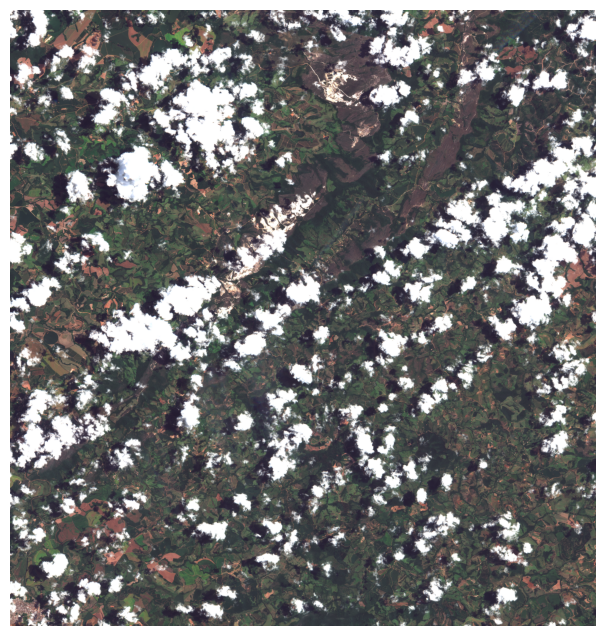

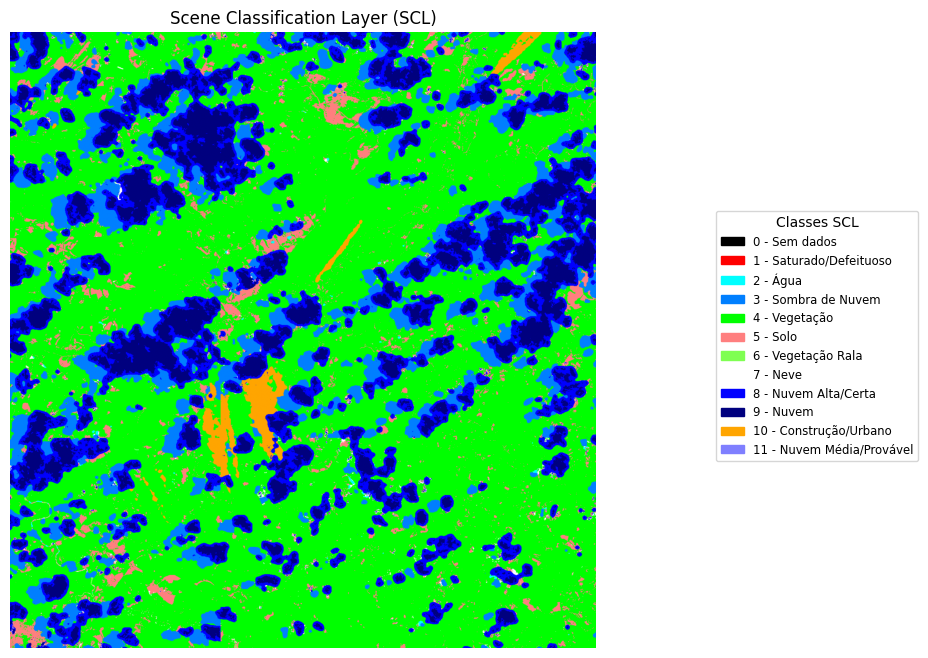

In [99]:
date = "2025_02_24"

carcara.api.downloadFile( date + ".tif" )
carcara.api.downloadFile( date + "_scl.tif" )

carcara.dataset.show(date)
carcara.dataset.showSCL(date)

print("")

In [93]:
carcara.api.downloadFile( date + ".tif" )
carcara.api.downloadFile( date + "_scl.tif" )

Arquivo salvo em: 2018_12_18.tif
Arquivo salvo em: 2018_12_18_scl.tif


True

In [42]:
X = carcara.dataset.open_tif("2018_12_13")
mask = carcara.dataset.open_tif("2018_12_13_scl")

In [43]:
X.shape

(12, 3137, 2983)

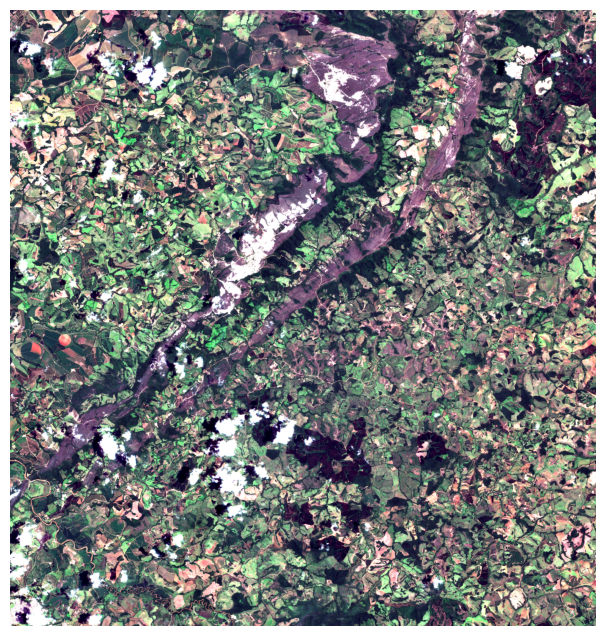

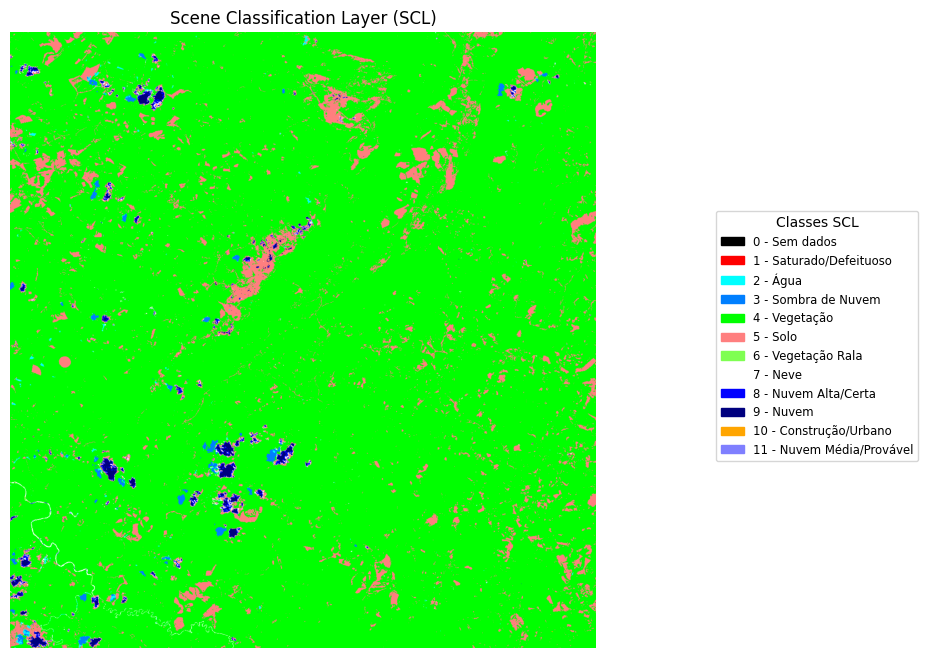

In [95]:
carcara.dataset.show(date)
carcara.dataset.showSCL(date)
print("\n")